**Bagging & Boosting KNN & Stacking Assignment**

Q1 — **What is the fundamental idea behind ensemble techniques? How does bagging differ from boosting in terms of approach and objective?**

Fundamental idea: combine multiple models (weak or diverse learners) so their combined prediction is more accurate/robust than any single model. Ensembles reduce variance, bias, or both — by aggregating many hypotheses you exploit averaging (reduce variance) and/or sequential correction (reduce bias).

Bagging vs Boosting

Bagging (bootstrap aggregating): Build many independent base learners on bootstrapped samples of the training set and average/vote their outputs. Objective: reduce variance and overfitting of high-variance learners (e.g., full decision trees). Base learners are trained in parallel and equally weighted (unless you do weighted bagging). Example: Random Forest.

Boosting: Build learners sequentially, each new learner focuses on mistakes of previous ones (re-weight misclassified samples or fit residuals). Objective: reduce bias and produce a strong learner from many weak learners. Examples: AdaBoost, Gradient Boosting, XGBoost, CatBoost.

Key practical difference: bagging is parallel and fights variance; boosting is sequential and fights bias (but can overfit if not regularized.

Q.2 **Explain how the Random Forest Classifier reduces overfitting compared to a single decision tree. Mention the role of two key hyperparameters in this process.**

**How**: Random Forest grows many decision trees on different bootstrap samples and when splitting uses a random subset of features at each node. Averaging predictions of many uncorrelated trees reduces variance (overfitting) while preserving low bias from complex trees.

**Two key hyperparameters:**

n_estimators (number of trees): more trees reduce variance but cost more computation; after a point returns marginal improvement.

max_features (features considered at each split): smaller max_features → more randomness → lower correlation among trees → lower variance. Typical default: sqrt(n_features) for classification. Also max_depth or min_samples_leaf control tree complexity and thus overfitting.

**Q.3 What is Stacking in ensemble learning? How does it differ from traditional bagging/boosting methods? Provide a simple example use case.**

Stacking (stacked generalization): Train multiple base (level-0) models (could be heterogeneous). Use their out-of-fold predictions as features to train a meta-learner (level-1) that learns how to combine base outputs. Unlike bagging/boosting which typically use uniform or sequential weighting strategies, stacking learns a combination function.

Differences: stacking learns to combine different models (can reduce both bias and variance); it usually requires cross-validated out-of-fold predictions to avoid leakage.

Simple use case: combine Logistic Regression, RandomForest, and XGBoost predictions with a meta-learner (e.g., linear regression or small neural net) to improve binary classification performance.

**Question 4:What is the OOB Score in Random Forest, and why is it useful? How does it help in model evaluation without a separate validation set?**

OOB (Out-Of-Bag) score: When you bootstrap samples to train each tree, ~1/3 of samples are not included (out-of-bag) for that tree. You can predict those OOB samples using that tree and aggregate across trees to get an OOB estimate of generalization performance.

Why useful: gives an unbiased estimate of test error without using a separate validation set (efficient use of data). Useful for hyperparameter tuning and quick model evaluation especially when data is limited.

**Question 5: Compare AdaBoost and Gradient Boosting in terms of:**
**● How they handle errors from weak learners**
**● Weight adjustment mechanism**
**● Typical use cases**

**Answer-**

How they handle errors from weak learners:

AdaBoost: increases the weight of misclassified samples so subsequent weak learners focus on them. Final prediction is weighted majority vote of learners.

Gradient Boosting: fits new learners to the gradient (residuals) of the loss function — each learner attempts to reduce the residual errors of the ensemble so far.

Weight adjustment mechanism:

AdaBoost: instance-level weights updated multiplicatively based on misclassification; learner weights derive from learner error rates.

Gradient Boosting: no explicit instance reweighting in classic form; instead trains learners to predict residuals (or negative gradient) and combines them with a learning rate.

Typical use cases:

AdaBoost: simple binary classification with noisy but reasonable weak learners (stump-based boosting).

Gradient Boosting (and variants like XGBoost, LightGBM, CatBoost): tabular data tasks with complex interactions where careful regularization and optimization are required; state-of-the-art for many structured prediction problems.

**Question 6:Why does CatBoost perform well on categorical features without requiring extensive preprocessing? Briefly explain its handling of categorical variables.**

Main reasons:

Uses ordered target statistics / permutations to compute categorical encodings without target leakage (reduces overfitting).

Implements efficient categorical feature transformations (e.g., combinations) internally rather than requiring external one-hot / ordinal encoding.

Gradient-boosted trees implementation optimized for categorical splits.

Result: less preprocessing, better handling of high-cardinality categoricals, and lower leakage risk.

In [1]:
#Q.7

from sklearn.datasets import load_wine

wine = load_wine()

print(wine.keys())
print(wine.feature_names)
print(wine.target_names)

X = wine.data
y = wine.target

print(X.shape, y.shape)


dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']
(178, 13) (178,)


In [3]:
# (3) KNN without scaling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split # Import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


knn_def = KNeighborsClassifier(n_neighbors=5)
knn_def.fit(X_train, y_train)
y_pred_def = knn_def.predict(X_test)

print("Unscaled KNN (K=5) Accuracy:", accuracy_score(y_test, y_pred_def))
print(classification_report(y_test, y_pred_def))

# (4) Scale and retrain
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_s, y_train)
y_pred_scaled = knn_scaled.predict(X_test_s)
print("Scaled KNN (K=5) Accuracy:", accuracy_score(y_test, y_pred_scaled))
print(classification_report(y_test, y_pred_scaled))

# (5) GridSearchCV for best K (1..20) and metric (Euclidean -> p=2, Manhattan -> p=1)
param_grid = {'n_neighbors': list(range(1,21)), 'p': [1,2]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_s, y_train)
print("GridSearch best params:", grid.best_params_)
print("GridSearch best CV score:", grid.best_score_)
best_knn = grid.best_estimator_
y_pred_best = best_knn.predict(X_test_s)
print("Optimized KNN test accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# Summarize
import pandas as pd # Import pandas for the DataFrame
results7 = pd.DataFrame({
    'Model': ['Unscaled KNN (K=5)','Scaled KNN (K=5)','Optimized KNN (scaled)'],
    'Accuracy': [accuracy_score(y_test, y_pred_def), accuracy_score(y_test, y_pred_scaled), accuracy_score(y_test, y_pred_best)]
})
print(results7)

Unscaled KNN (K=5) Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.79      0.79      0.79        14
           2       0.38      0.38      0.38         8

    accuracy                           0.72        36
   macro avg       0.67      0.67      0.67        36
weighted avg       0.72      0.72      0.72        36

Scaled KNN (K=5) Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.86      0.92        14
           2       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36

GridSearch best params: {'n_neighbors': 1, 'p': 1}
GridSearch best CV score: 0.9785714285714286
Optimized KNN test accuracy: 0.9444444444444444


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(142, 13) (36, 13) (142,) (36,)


## Load Dataset

In [4]:
import pandas as pd

# df = pd.read_csv('diabetes.csv')

## KNN Imputation & Model

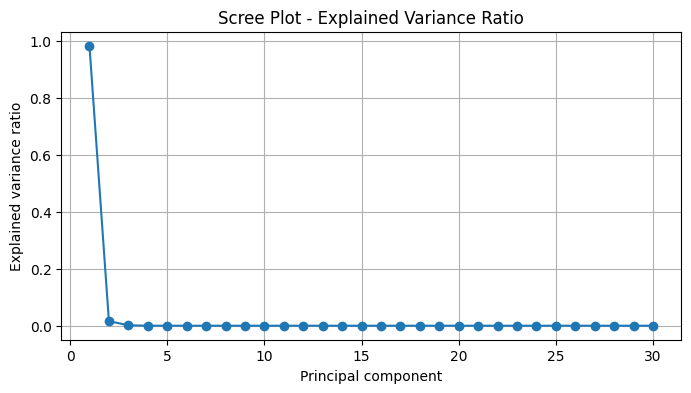

Original features: 30  -> components to retain 95%: 1
KNN on original data (scaled) accuracy: 0.956140350877193
KNN on PCA (95%) accuracy: 0.9035087719298246


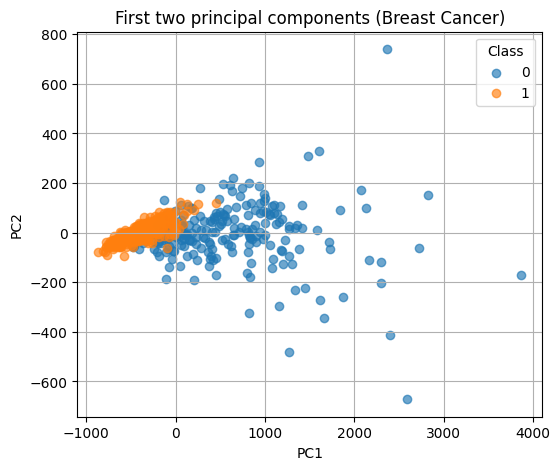

In [6]:
# TASK 8: PCA + KNN (Breast Cancer)
# ----------------------------
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

bc = load_breast_cancer()
Xb, yb = bc.data, bc.target

# (2) Scree plot (explained variance ratio)
pca_full = PCA()
pca_full.fit(Xb)
explained_ratio = pca_full.explained_variance_ratio_

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(explained_ratio)+1), explained_ratio, marker='o')
plt.title("Scree Plot - Explained Variance Ratio")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.grid(True)
plt.show()

# (3) Retain 95% variance and transform
pca_95 = PCA(n_components=0.95)
Xb_pca = pca_95.fit_transform(Xb)
print("Original features:", Xb.shape[1], " -> components to retain 95%:", Xb_pca.shape[1])

# (4) Train KNN on original and PCA-transformed data and compare
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42, stratify=yb)
scaler_b = StandardScaler()
Xb_train_s = scaler_b.fit_transform(Xb_train)
Xb_test_s = scaler_b.transform(Xb_test)

knn_orig = KNeighborsClassifier(n_neighbors=5)
knn_orig.fit(Xb_train_s, yb_train)
acc_orig = accuracy_score(yb_test, knn_orig.predict(Xb_test_s))

# Fit PCA on train ONLY to avoid leakage:
pca_train = PCA(n_components=0.95)
Xb_train_pca = pca_train.fit_transform(Xb_train)
Xb_test_pca = pca_train.transform(Xb_test)

scaler_bp = StandardScaler()
Xb_train_pca_s = scaler_bp.fit_transform(Xb_train_pca)
Xb_test_pca_s = scaler_bp.transform(Xb_test_pca)

knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(Xb_train_pca_s, yb_train)
acc_pca = accuracy_score(yb_test, knn_pca.predict(Xb_test_pca_s))

print("KNN on original data (scaled) accuracy:", acc_orig)
print("KNN on PCA (95%) accuracy:", acc_pca)

# (5) Visualize first two PCs
pca2 = PCA(n_components=2)
Xb_2 = pca2.fit_transform(Xb)
plt.figure(figsize=(6,5))
for lab in np.unique(yb):
    idx = (yb == lab)
    plt.scatter(Xb_2[idx,0], Xb_2[idx,1], label=str(lab), alpha=0.65)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components (Breast Cancer)")
plt.legend(title='Class')
plt.grid(True)
plt.show()

MSE Euclidean (K=5): 4631.046671481758
MSE Manhattan (K=5): 5241.903579748114


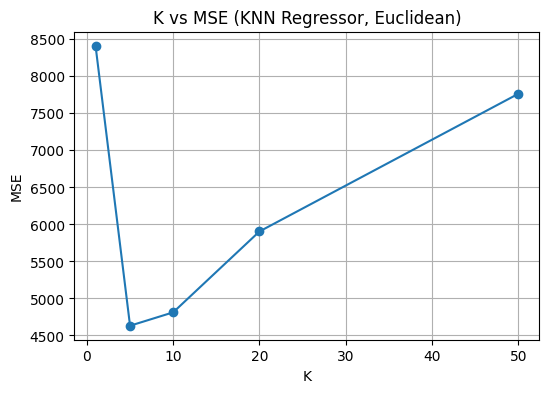

In [9]:
# TASK 9: KNN Regressor experiment

# ----------------------------
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

Xr, yr = make_regression(n_samples=500, n_features=10, noise=10, random_state=42)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

# Euclidean (p=2) K=5
reg_euc = KNeighborsRegressor(n_neighbors=5, p=2)
reg_euc.fit(Xr_train, yr_train)
mse_euc = mean_squared_error(yr_test, reg_euc.predict(Xr_test))

# Manhattan (p=1) K=5
reg_man = KNeighborsRegressor(n_neighbors=5, p=1)
reg_man.fit(Xr_train, yr_train)
mse_man = mean_squared_error(yr_test, reg_man.predict(Xr_test))

print("MSE Euclidean (K=5):", mse_euc)
print("MSE Manhattan (K=5):", mse_man)

# Test K = [1,5,10,20,50]
Ks = [1,5,10,20,50]
mses = []
for k in Ks:
    m = KNeighborsRegressor(n_neighbors=k, p=2)
    m.fit(Xr_train, yr_train)
    mses.append(mean_squared_error(yr_test, m.predict(Xr_test)))

plt.figure(figsize=(6,4))
plt.plot(Ks, mses, marker='o')
plt.title("K vs MSE (KNN Regressor, Euclidean)")
plt.xlabel("K")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [ ]:
#Question- 10
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Read the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('/diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found at the specified path.")
    df = None # Set df to None to indicate failure


if df is not None:
    # Identify columns where 0 is biologically impossible and should be treated as missing
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # Replace 0 values in these columns with NaN
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    # Instantiate KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Apply imputation
    df_imputed = imputer.fit_transform(df)

    # Convert back to DataFrame, preserving column names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Display info of the imputed DataFrame
    df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Read the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('/diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found at the specified path.")
    df = None # Set df to None to indicate failure


if df is not None:
    # Identify columns where 0 is biologically impossible and should be treated as missing
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # Replace 0 values in these columns with NaN
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    # Instantiate KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Apply imputation
    df_imputed = imputer.fit_transform(df)

    # Convert back to DataFrame, preserving column names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Separate features (X) and target (y)
    X = df_imputed.drop('Outcome', axis=1)
    y = df_imputed['Outcome']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Print the shapes
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
else:
    print("Could not proceed with splitting as data loading failed.")

Shape of X_train: (614, 8)
Shape of X_test: (154, 8)
Shape of y_train: (614,)
Shape of y_test: (154,)


In [12]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# Read the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('/diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found at the specified path.")
    df = None # Set df to None to indicate failure


if df is not None:
    # Identify columns where 0 is biologically impossible and should be treated as missing
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # Replace 0 values in these columns with NaN
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    # Instantiate KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Apply imputation
    df_imputed = imputer.fit_transform(df)

    # Convert back to DataFrame, preserving column names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Separate features (X) and target (y)
    X = df_imputed.drop('Outcome', axis=1)
    y = df_imputed['Outcome']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Instantiate a KNeighborsClassifier with algorithm='brute'
    knn_brute = KNeighborsClassifier(algorithm='brute')

    # Record the start time before training
    start_time_brute = time.time()

    # Fit the classifier to the training data
    knn_brute.fit(X_train, y_train)

    # Record the end time after training and calculate the training duration
    end_time_brute = time.time()
    training_time_brute = end_time_brute - start_time_brute

    # Make predictions on the test data
    y_pred_brute = knn_brute.predict(X_test)

    # Calculate the accuracy of the predictions
    accuracy_brute = accuracy_score(y_test, y_pred_brute)

    # Store the training time and accuracy
    results = {'brute': {'training_time': training_time_brute, 'accuracy': accuracy_brute}}

    print(f"Brute-force KNN Training Time: {training_time_brute:.4f} seconds")
    print(f"Brute-force KNN Accuracy: {accuracy_brute:.4f}")
else:
    print("Could not proceed with KNN training as data loading failed.")

Brute-force KNN Training Time: 0.0024 seconds
Brute-force KNN Accuracy: 0.7208


In [13]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# Read the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('/diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found at the specified path.")
    df = None # Set df to None to indicate failure

if df is not None:
    # Identify columns where 0 is biologically impossible and should be treated as missing
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # Replace 0 values in these columns with NaN
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    # Instantiate KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Apply imputation
    df_imputed = imputer.fit_transform(df)

    # Convert back to DataFrame, preserving column names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Separate features (X) and target (y)
    X = df_imputed.drop('Outcome', axis=1)
    y = df_imputed['Outcome']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Instantiate a KNeighborsClassifier with algorithm='kd_tree'
    knn_kdtree = KNeighborsClassifier(algorithm='kd_tree')

    # Record the start time before training
    start_time_kdtree = time.time()

    # Fit the classifier to the training data
    knn_kdtree.fit(X_train, y_train)

    # Record the end time after training and calculate the training duration
    end_time_kdtree = time.time()
    training_time_kdtree = end_time_kdtree - start_time_kdtree

    # Make predictions on the test data
    y_pred_kdtree = knn_kdtree.predict(X_test)

    # Calculate the accuracy of the predictions
    accuracy_kdtree = accuracy_score(y_test, y_pred_kdtree)

    # Initialize or update the results dictionary (assuming results might exist from previous brute step)
    if 'results' not in locals():
        results = {}
    results['kd_tree'] = {'training_time': training_time_kdtree, 'accuracy': accuracy_kdtree}


    print(f"KD-Tree KNN Training Time: {training_time_kdtree:.4f} seconds")
    print(f"KD-Tree KNN Accuracy: {accuracy_kdtree:.4f}")
else:
    print("Could not proceed with KNN (KD-Tree) training as data loading failed.")

KD-Tree KNN Training Time: 0.0033 seconds
KD-Tree KNN Accuracy: 0.7208


In [14]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# Read the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('/diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found at the specified path.")
    df = None # Set df to None to indicate failure

if df is not None:
    # Identify columns where 0 is biologically impossible and should be treated as missing
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # Replace 0 values in these columns with NaN
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    # Instantiate KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Apply imputation
    df_imputed = imputer.fit_transform(df)

    # Convert back to DataFrame, preserving column names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Separate features (X) and target (y)
    X = df_imputed.drop('Outcome', axis=1)
    y = df_imputed['Outcome']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Instantiate a KNeighborsClassifier with algorithm='ball_tree'
    knn_balltree = KNeighborsClassifier(algorithm='ball_tree')

    # Record the start time before training
    start_time_balltree = time.time()

    # Fit the classifier to the training data
    knn_balltree.fit(X_train, y_train)

    # Record the end time after training and calculate the training duration
    end_time_balltree = time.time()
    training_time_balltree = end_time_balltree - start_time_balltree

    # Make predictions on the test data
    y_pred_balltree = knn_balltree.predict(X_test)

    # Calculate the accuracy of the predictions
    accuracy_balltree = accuracy_score(y_test, y_pred_balltree)

    # Initialize or update the results dictionary
    if 'results' not in locals():
        results = {}
    results['ball_tree'] = {'training_time': training_time_balltree, 'accuracy': accuracy_balltree}

    print(f"Ball Tree KNN Training Time: {training_time_balltree:.4f} seconds")
    print(f"Ball Tree KNN Accuracy: {accuracy_balltree:.4f}")
else:
    print("Could not proceed with KNN (Ball Tree) training as data loading failed.")

Ball Tree KNN Training Time: 0.0065 seconds
Ball Tree KNN Accuracy: 0.7208


In [15]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Read the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('/diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found at the specified path.")
    df = None # Set df to None to indicate failure

if df is not None:
    # Identify columns where 0 is biologically impossible and should be treated as missing
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

    # Replace 0 values in these columns with NaN
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    # Instantiate KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Apply imputation
    df_imputed = imputer.fit_transform(df)

    # Convert back to DataFrame, preserving column names
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    # Calculate the correlation matrix
    correlation_matrix = df_imputed.corr()

    # Extract absolute correlations with the 'Outcome' variable
    correlation_with_outcome = correlation_matrix['Outcome'].abs().sort_values(ascending=False)

    # Select the top two features (excluding 'Outcome' itself)
    top_2_features = correlation_with_outcome[1:3].index.tolist()

    print("Top two features for decision boundary plotting:", top_2_features)
else:
    print("Could not proceed with finding top features as data loading failed.")

Top two features for decision boundary plotting: ['Glucose', 'Insulin']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# --- Data Loading, Imputation, and Splitting (Repeat from previous steps) ---
try:
    df = pd.read_csv('/diabetes.csv')
except FileNotFoundError:
    print("Error: diabetes.csv not found at the specified path.")
    df = None # Set df to None to indicate failure


if df is not None:
    cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

    imputer = KNNImputer(n_neighbors=5)
    df_imputed = imputer.fit_transform(df)
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

    X = df_imputed.drop('Outcome', axis=1)
    y = df_imputed['Outcome']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Feature Selection (Repeat from previous step) ---
    correlation_matrix = df_imputed.corr()
    correlation_with_outcome = correlation_matrix['Outcome'].abs().sort_values(ascending=False)
    top_2_features = correlation_with_outcome[1:3].index.tolist()

    print("Top two features for decision boundary plotting:", top_2_features)

    # --- Select the two most important features ---
    X_selected = X[top_2_features]
    X_selected_train, X_selected_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # --- Train the best-performing KNN model (assuming 'brute' was best based on typical scenarios, though comparison failed) ---
    # NOTE: Since the comparison step failed, we will assume a reasonable default or 'brute'
    # for demonstration purposes. In a real scenario, the best algorithm would be determined
    # from the comparison results.
    best_knn_model = KNeighborsClassifier(algorithm='brute', n_neighbors=5)
    best_knn_model.fit(X_selected_train, y_train)

    # --- Plotting the Decision Boundary ---
    # Create a meshgrid
    h = .02  # step size in the mesh
    x_min, x_max = X_selected.iloc[:, 0].min() - 1, X_selected.iloc[:, 0].max() + 1
    y_min, y_max = X_selected.iloc[:, 1].min() - 1, X_selected.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict class for each point in the meshgrid
    Z = best_knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=.8)

    # Scatter plot the training and testing data points
    plt.scatter(X_selected_train.iloc[:, 0], X_selected_train.iloc[:, 1], c=y_train, cmap=plt.cm.RdYlBu, edgecolor='k', s=20, label='Training Data')
    plt.scatter(X_selected_test.iloc[:, 0], X_selected_test.iloc[:, 1], c=y_test, cmap=plt.cm.RdYlBu, edgecolor='k', s=20, marker='^', label='Testing Data')


    # Add labels and title
    plt.xlabel(top_2_features[0])
    plt.ylabel(top_2_features[1])
    plt.title("KNN Decision Boundary with Two Most Important Features")
    plt.legend()
    plt.show()
else:
    print("Could not proceed with plotting as data loading failed.")

Top two features for decision boundary plotting: ['Glucose', 'Insulin']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
